In [ ]:
# Import library
%pip install seaborn
%pip install openpyxl
%pip install mlxtend
%pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor

## Cleaning
Renaming df columns & adding two new columns:
- Year
- Quarter

In [72]:
df = pd.read_csv('./master_normalised.csv')
df= df.rename(columns={
     'quarter': "Time_Period",
     'Total Demand': "Electricity_Demand",
     'GDP (AUD, Millions)':"GDP",
     'Population (000,s)':"Population",
     'Coal_Price (PCOALAUUSDM)':"Coal_Price",
     'Premium unleaded petrol (95 RON) (cpl)':"Premium_Unleaded_Petrol",
     'Regular unleaded petrol (91 RON) (cpl)':"Regular_Unleaded_Petrol",
     'Automotive diesel (cpl)':"Automotive_Diesel",
     'Automotive LPG (cpl)':"Automotive_LPG",
     'Temperature(max)':"Temperature_Max",
     'Temperature(avg)':"Temperature_Avg",
     'Temperature(min)':"Temperature_Min",
     'electricity_price':"Electricity_Price",
     'renewable_energy':"Renewables_Price"
})
df.columns.tolist()

df['Time_Period'] = pd.to_datetime(df['Time_Period'])
# Extract the year
df['Year'] = df['Time_Period'].dt.year
# Extract the quarter
df['Quarter'] = df['Time_Period'].dt.quarter
df.head()

,Time_Period,Electricity_Demand,GDP,Population,Coal_Price,Premium_Unleaded_Petrol,Regular_Unleaded_Petrol,Automotive_Diesel,Automotive_LPG,Temperature_Max,Temperature_Avg,Temperature_Min,Electricity_Price,Renewables_Price,Year,Quarter
0,2010-01-01,0.930894,0.000000,0.000000,0.558774,0.275,0.363636,0.234043,0.228571,0.969492,0.999016,0.971787,0.303922,0.000000,2010,1
1,2010-04-01,0.860334,0.118536,0.018352,0.632759,0.350,0.431818,0.340426,0.171429,0.510734,0.279528,0.173197,0.250000,0.027860,2010,2
2,2010-07-01,1.000000,0.141274,0.038033,0.564323,0.250,0.318182,0.297872,0.000000,0.183051,0.135827,0.155956,0.196078,0.055720,2010,3
3,2010-10-01,0.737070,0.232885,0.056494,0.719280,0.275,0.363636,0.319149,0.200000,0.606780,0.670276,0.611285,0.142157,0.083580,2010,4
4,2011-01-01,0.858217,0.120926,0.082599,1.000000,0.575,0.613636,0.595745,0.542857,0.912994,0.981299,0.978840,0.088235,0.111441,2011,1


## Correlation Analysis

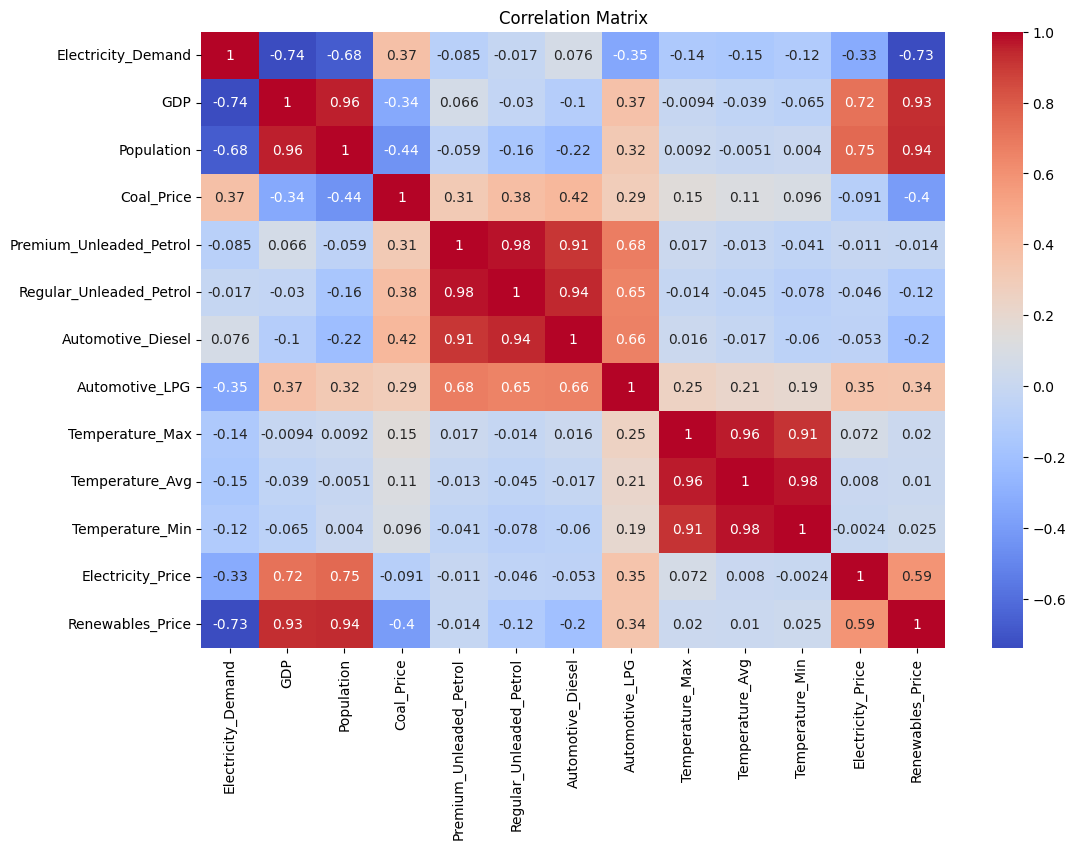

Electricity_Demand         1.000000
Coal_Price                 0.371817
Automotive_Diesel          0.076427
Regular_Unleaded_Petrol   -0.017037
Premium_Unleaded_Petrol   -0.085003
Temperature_Min           -0.123126
Temperature_Max           -0.138913
Temperature_Avg           -0.152526
Electricity_Price         -0.327437
Automotive_LPG            -0.346566
Population                -0.676495
Renewables_Price          -0.732432
GDP                       -0.738298
Name: Electricity_Demand, dtype: float64


In [73]:
# Setting 'Time_Period' as index
df.set_index('Time_Period', inplace=True)

# Exclude Year and Quarter columns from correlation analysis
df_analysis = df.drop(columns=['Year', 'Quarter'], errors='ignore')

# Calculate correlation matrix
corr_matrix = df_analysis.corr()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Display correlation values with Electricity_Demand specifically
electricity_demand_correlation = corr_matrix['Electricity_Demand'].sort_values(ascending=False)
print(electricity_demand_correlation)

## Train/Test Split
- 2010-2018 as training
- 2019-2020 as testing
- Average temperature used for temperature

In [75]:
# Splitting the data according to the specified years and quarters
train = df[(df['Year'] < 2019)]
test = df[((df['Year'] >= 2019) & (df['Year'] < 2021))]

# Separate features and target variable for both training and testing sets
X_train = train.drop(['Electricity_Demand', 'Year', 'Quarter', 'Temperature_Min', 'Temperature_Max'], axis=1)
y_train = train['Electricity_Demand']
X_test = test.drop(['Electricity_Demand', 'Year', 'Quarter','Temperature_Min', 'Temperature_Max'], axis=1)
y_test = test['Electricity_Demand']

## Modelling
Comparing the RMSE & R squared for the following models:
- Linear Regression
- Random Forest
- Gradient Boosting
- XGBoost

For each of the following models do the following:
1. Feature Selection using select_features():
   - Recursive Feature Elimination with Cross-Validation
   - Uses given model as the estimator
   - Returns the most optimal features & Plots the RMSE vs Number of Features
2. Find each models RMSE & R squared by running it against its optimal features retrieved from point 1 for the respective model

3. XGBoost is the best 

Processing Linear Regression...


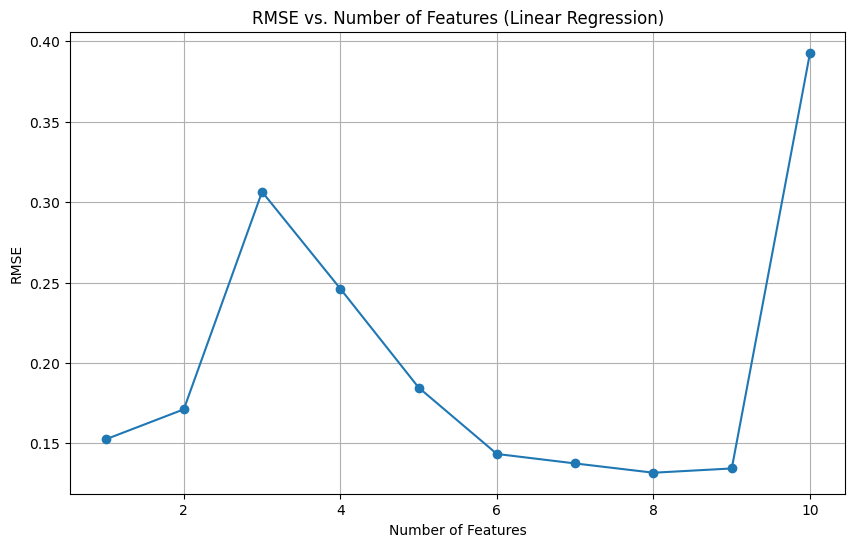

Optimal number of features for Linear Regression: 8
Selected features for Linear Regression: ['GDP', 'Population', 'Coal_Price', 'Premium_Unleaded_Petrol', 'Regular_Unleaded_Petrol', 'Temperature_Avg', 'Electricity_Price', 'Renewables_Price']
Feature rankings for Linear Regression: {'GDP': 1, 'Population': 1, 'Coal_Price': 1, 'Premium_Unleaded_Petrol': 1, 'Regular_Unleaded_Petrol': 1, 'Automotive_Diesel': 3, 'Automotive_LPG': 2, 'Temperature_Avg': 1, 'Electricity_Price': 1, 'Renewables_Price': 1}
Linear Regression - RMSE: 0.1953, R-squared: -2.9416

Processing Random Forest...


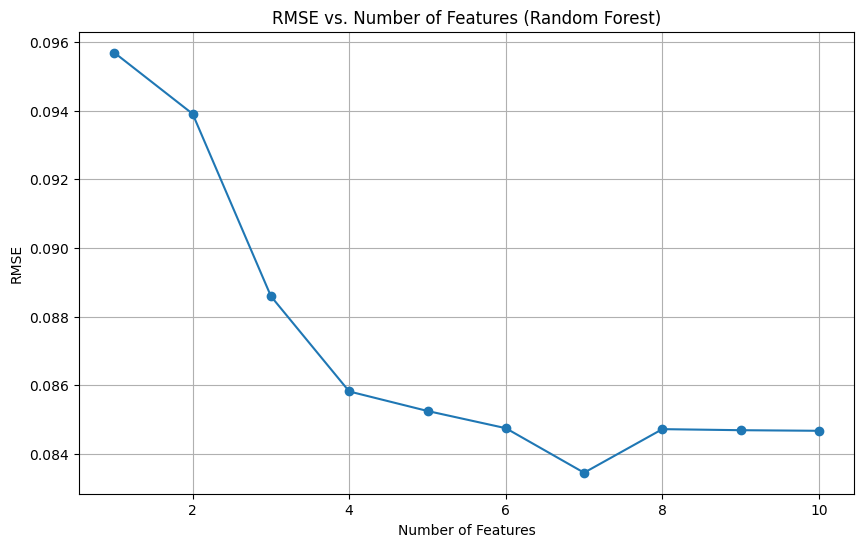

Optimal number of features for Random Forest: 7
Selected features for Random Forest: ['GDP', 'Population', 'Coal_Price', 'Regular_Unleaded_Petrol', 'Automotive_Diesel', 'Temperature_Avg', 'Renewables_Price']
Feature rankings for Random Forest: {'GDP': 1, 'Population': 1, 'Coal_Price': 1, 'Premium_Unleaded_Petrol': 4, 'Regular_Unleaded_Petrol': 1, 'Automotive_Diesel': 1, 'Automotive_LPG': 3, 'Temperature_Avg': 1, 'Electricity_Price': 2, 'Renewables_Price': 1}
Random Forest - RMSE: 0.0879, R-squared: 0.2008

Processing Gradient Boosting...


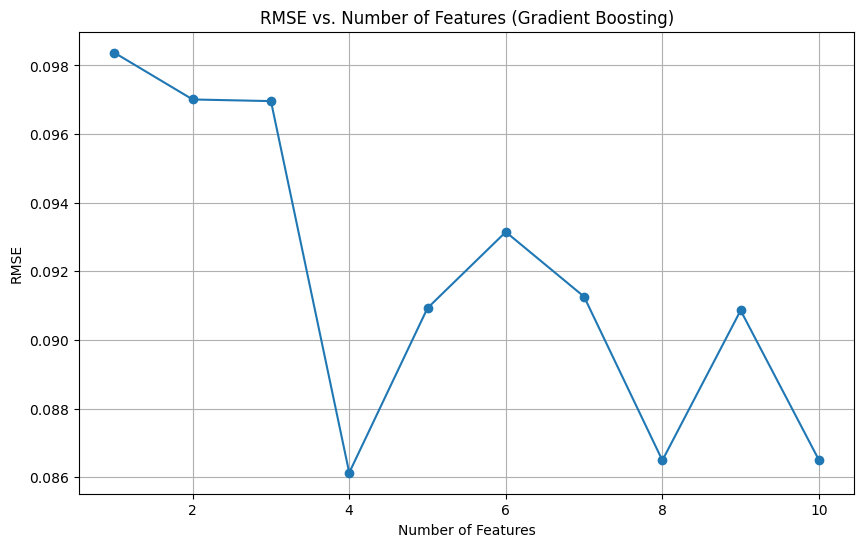

Optimal number of features for Gradient Boosting: 4
Selected features for Gradient Boosting: ['GDP', 'Population', 'Temperature_Avg', 'Renewables_Price']
Feature rankings for Gradient Boosting: {'GDP': 1, 'Population': 1, 'Coal_Price': 3, 'Premium_Unleaded_Petrol': 5, 'Regular_Unleaded_Petrol': 4, 'Automotive_Diesel': 2, 'Automotive_LPG': 7, 'Temperature_Avg': 1, 'Electricity_Price': 6, 'Renewables_Price': 1}
Gradient Boosting - RMSE: 0.0647, R-squared: 0.5679

Processing XGBoost...


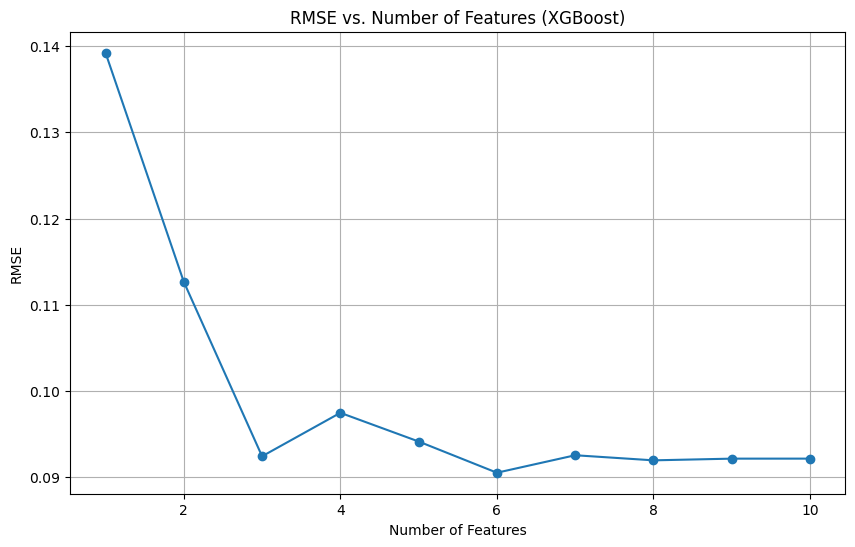

Optimal number of features for XGBoost: 6
Selected features for XGBoost: ['GDP', 'Population', 'Coal_Price', 'Premium_Unleaded_Petrol', 'Automotive_Diesel', 'Temperature_Avg']
Feature rankings for XGBoost: {'GDP': 1, 'Population': 1, 'Coal_Price': 1, 'Premium_Unleaded_Petrol': 1, 'Regular_Unleaded_Petrol': 3, 'Automotive_Diesel': 1, 'Automotive_LPG': 2, 'Temperature_Avg': 1, 'Electricity_Price': 5, 'Renewables_Price': 4}
XGBoost - RMSE: 0.0576, R-squared: 0.6569



In [81]:
# Evaluate model performance
def train_eval_model(model, X_train, y_train, X_test, y_test, features):
    model.fit(X_train[features], y_train)
    y_pred = model.predict(X_test[features])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

# Return optimal features for a given model
def select_features(model, X_train, y_train, model_name):
    rfecv = RFECV(estimator=model, step=1, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
    rfecv.fit(X_train, y_train)
    
    # Get RMSE values
    rmse_values = np.sqrt(-rfecv.cv_results_['mean_test_score'])
    
    # RMSE vs. Number of Features
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(rmse_values) + 1), rmse_values, marker='o', linestyle='-')
    plt.title(f'RMSE vs. Number of Features ({model_name})')
    plt.xlabel('Number of Features')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()
    
    # Output optimal features
    selected_features = [f for f, s in zip(X_train.columns, rfecv.support_) if s]
    print(f"Optimal number of features for {model_name}: {len(selected_features)}")
    print(f"Selected features for {model_name}: {selected_features}")
    feature_rankings = {feature: rank for feature, rank in zip(X_train.columns, rfecv.ranking_)}
    print(f"Feature rankings for {model_name}: {feature_rankings}")
    
    return selected_features

# Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=0)
}

# Iterate over each model, select its optimal features, and evaluate performance
for name, model in models.items():
    print(f"Processing {name}...")
    selected_features = select_features(model, X_train, y_train, name)
    rmse, r2 = train_eval_model(model, X_train, y_train, X_test, y_test, selected_features)
    print(f"{name} - RMSE: {rmse:.4f}, R-squared: {r2:.4f}\n")

## Running XGBoost using all features without feature selection gives better results than recursive feature elimination?

In [91]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=0)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate the RMSE for the test set
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Calculate the R-squared value for the test set
test_r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test RMSE: {test_rmse_xgb:.4f}")
print(f"XGBoost Test R-squared: {test_r2_xgb:.4f}")

XGBoost Test RMSE: 0.0534
XGBoost Test R-squared: 0.7049
